<a href="https://colab.research.google.com/github/Varshan98/DSL_group_03/blob/main/Lab_3/Lab3Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#30.110 Digital Systems Lab Group 3

Members: Ahmad Danish Bin Azil (1006659), Leow Jing Ting (1006392), Lim Yee Kiat (1004224), Matthew Yim Tong Wong (1009835), Rk Suriya Varshan Suriyakumar Ramesh (1006362)

## Design Steps

1. Design and define interfaces for the SPI ADC driver, 7-segment display controller, and UART transmitter modules.
2. Implement each module in Verilog, ensuring accurate timing and data handling.
3. Verify individual module functionality using... .
4. Synthesize the design, constrain it, generate the bitstream, and program the CMOD A7 FPGA.
5. Test and validate the complete system by observing display, UART output, and ADC accuracy.

## Setup

In [1]:
print("[INFO]: Init the Verilog ENV")
!pip install git+https://github.com/pe8sutd/eda4u &> /dev/null
!git clone https://github.com/pe8sutd/eda4u &> /dev/null
%load_ext plugin

[INFO]: Init the Verilog ENV


## ADC Light Sensor code (changed line 89 to match our wiring of the FPGA and 7-segment timer)

In [ ]:
/*
 * Module: top_module
 * Date : 2024/03/21
 * Author : Maoyang
 * Description:
 * This top-level module integrates various components to demonstrate a complete system design,
 * including a clock divider, a 7-segment display driver, and an external ADC (Analog-to-Digital Converter) MCP3202 interface.
 * The system operates based on the input from a system clock (sysclk) and two buttons (btn).
 *
 * Inputs:
 * - sysclk: The system clock input.
 * - btn: 2-button input for system control. btn[1] is used as a reset signal.
 * - adc_dout: Digital output from the MCP3202 ADC.
 *
 * Outputs:
 * - pio37 to pio48: Pins connected to a 7-segment display for displaying ADC data.
 * - led: 2-bit LED output for indicating system status or errors (not implemented in the given code).
 * - adc_din: Serial data input to the ADC.
 * - adc_clk: Clock signal for the ADC.
 * - adc_csn: Chip select signal for the ADC, active low.
 *
 * Functionality:
 * 1. The module starts with configuring the system reset based on the btn[1] input.
 * 2. It then sets up three clock dividers to generate different frequencies needed for the 7-segment display and the ADC.
 * 3. The 7-segment display is driven by the `drv_segment` module, which updates the display based on the ADC data.
 * 4. The MCP3202 ADC is configured to operate in single channel mode (CHANNEL 0), with a 2MHz clock.
 * 5. ADC sampling occurs at a frequency of 1Hz, triggered by the CLK1Hz signal. When new ADC data is valid (adc_vaild), it is displayed on the 7-segment display.
 *
 * Implementation Details:
 * - Clock division is achieved using instances of the `clock_div` module, parameterized to produce the required frequencies for the ADC and the 7-segment display.
 * - The 7-segment display configuration and updating are handled by the `drv_segment` module.
 * - The `drv_mcp3202` module interfaces with the MCP3202 ADC, handling the SPI communication and data conversion process.
 * - The ADC sampling and display update logic is implemented in an always block, which reacts to the ADC's valid data signal and the 1Hz clock signal.
 *
 * Notes:
 * - This module demonstrates handling of digital and analog inputs, clock management, and driving peripheral devices in a hardware description language.
 */
module top_module(
        input sysclk,
        input [1:0] btn,
        output pio37,
        output pio38,
        output pio39,
        output pio40,
        output pio41,
        output pio42,
        output pio43,
        output pio44,
        output pio45,
        output pio46,
        output pio47,
        output pio48,
        output [1:0] led,
        //External ADC MCP3202 Pin;
        output adc_din,
        output adc_clk,
        output adc_csn,
        input  adc_dout,
        //UART Tx Pin;
        output uart_rxd_out
);

//RESET SYSTEM CONFIG;
wire rstn;
assign rstn = ~btn[1];

//CLOCK TREE CONFIG;
wire CLK500Hz,CLK1Hz,CLK_ADC,CLK_UART,CLK2Hz;

clock_div clk_div_u1(rstn,sysclk,CLK500Hz);
clock_div clk_div_u2(rstn,CLK500Hz,CLK1Hz);
clock_div clk_div_u3(rstn,sysclk,CLK_ADC);
clock_div clk_div_u4(rstn,sysclk,CLK_UART);
clock_div clk_div_u5(rstn,sysclk,CLK2Hz);

defparam clk_div_u1.FREQ_INPUT  = 12_000_000;
defparam clk_div_u1.FREQ_OUTPUT = 500;
defparam clk_div_u2.FREQ_INPUT  = 500;
defparam clk_div_u2.FREQ_OUTPUT = 1;
defparam clk_div_u3.FREQ_INPUT  = 12_000_000;
defparam clk_div_u3.FREQ_OUTPUT = 2_000_000;
defparam clk_div_u4.FREQ_INPUT  = 12_000_000;
defparam clk_div_u4.FREQ_OUTPUT = 9600;
defparam clk_div_u5.FREQ_INPUT  = 12_000_000;
defparam clk_div_u5.FREQ_OUTPUT = 2;

//7SEGMENT DISPLAY CONFIG;
reg [11:0] Segment_data;
drv_segment segment_u0(rstn,CLK500Hz,{4'h0,Segment_data},{pio42,pio39,pio38,pio48},{pio45,pio47,pio40,pio43,pio44,pio46,pio37,pio41});

//EXTERNAL ADC MCP3202 CONFIG;
// DRV FREQ : 2MHZ;
// CHANNEL : ONLY CHANNEL 0;
localparam  SINGLE_CHAN0  = 2'b10;
localparam  SINGLE_CHAN1  = 2'b11;

reg adc_ready;
wire adc_vaild;
wire [11:0] adc_data;

drv_mcp3202 drv_mcp3202_u0(
    .rstn(rstn),
    .clk(CLK_ADC),
    .ap_ready(adc_ready),
    .ap_vaild(adc_vaild),
    .mode(SINGLE_CHAN0),
    .data(adc_data),

    .port_din(adc_dout),
    .port_dout(adc_din), //adc_din
    .port_clk(adc_clk),
    .port_cs(adc_csn)
);

// ADC SAMPLING EVENT (FREQ:1HZ)
always @(negedge rstn, posedge adc_vaild,posedge CLK1Hz) begin
    if(!rstn) begin
        adc_ready <= 1'b0;
        Segment_data <= 12'hABC;
    end else begin
        if(adc_vaild) begin
            Segment_data <= adc_data;
            adc_ready <= 1'b0;
        end
        else begin
            adc_ready <= 1'b1;
        end
    end
end


//UART Tx Event Config (FREQ:9600)

reg uart_ready;
wire uart_vaild;
reg [7:0] uart_data;
reg hl_sel;

drv_uart_tx drv_uart_u0(
    .clk(CLK_UART),
    .ap_rstn(rstn),
    .ap_ready(uart_ready),
    .ap_vaild(uart_vaild),
    .tx(uart_rxd_out),
    .pairty(1'b0),
    .data(uart_data)
);

always @(negedge rstn, posedge uart_vaild,negedge CLK2Hz) begin
    if(!rstn) begin
        uart_ready <= 1'b0;
        hl_sel <= 1'b0;
    end else begin
        if(uart_vaild) begin
            uart_data <= (hl_sel)? {4'h0, Segment_data[11:8]}: Segment_data[7:0];
            uart_ready   <= 1'b0;
        end
        else begin
            uart_ready  <= 1'b1;
            hl_sel      <= ~hl_sel;
        end
    end
end


endmodule

## ADC Light Sensor Circuitry

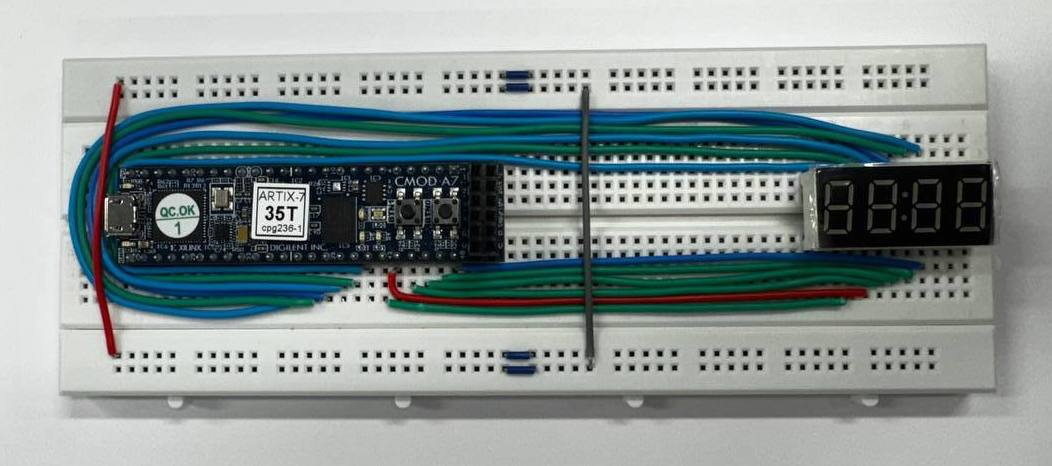

## Video Demo

https://youtu.be/A6nzKqLxYok

## Python Script (for windows laptop) to verify ADC light sensor functionality

In [4]:
import serial
import time

# Use Windows COM port
ser = serial.Serial('COM20', 9600, timeout=1)

print("Listening for 8-bit UART values every 1 second...")

try:
    while True:
        byte = ser.read()
        if byte:
            value = byte[0]
            print(f"Value: {value} (0x{value:02X})")
        time.sleep(0.05)  # Small pause to prevent 100% CPU usage

except KeyboardInterrupt:
    print("\nExiting...")
    ser.close()


ModuleNotFoundError: No module named 'serial'

## Challenges

- Time consuming to placed the wires neatly in the correct GPIO pins
- FPGA Board is unable to connect to a few members' computer even after troubleshooting by changing USB cable
- Time consuming to check accuracy of 7 segment display but managed to do it using arduino, Serial Port Assistant and also python code above  

## Lessons Learned

- Familiarise with the different communication protocols and actual use case of it
- Various troubleshooting methods when FPGA is not connecting to laptops

## Use of AI to Verify Results

- Utilizing AI tools like Gemini for syntax verification and understanding of Verilog code.
- Employing a Python verification script, with assistance from AI tools like ChatGPT and DeepSeek, to better understand and validate the 7-segment display functionality.

First Testbench

In [ ]:
//////////////////////////////////////////////////////////////////////////////////
// Company: 
// Engineer: 
// 
// Create Date: 10.04.2025 12:40:17
// Design Name: 
// Module Name: testbench
// Project Name: 
// Target Devices: 
// Tool Versions: 
// Description: 
// 
// Dependencies: 
// 
// Revision:
// Revision 0.01 - File Created
// Additional Comments:
// 
//////////////////////////////////////////////////////////////////////////////////


`timescale 1ns/1ps
module tb_chua_uart_rng;
  // Declare testbench signals.
  reg         sysclk;
  reg         rst;
  reg [31:0]  seed_1;
  reg [31:0]  seed_2;
  reg [31:0]  seed_3;
  wire [15:0] rnd_out;

  // Instantiate the Chua RNG module.
  chua_rng rng_uut (
    .sysclk(sysclk),
    .C1_seed(seed_1),
    .C2_seed(seed_2),
    .L_seed(seed_3),
    .rst(rst),
    .rnd(rnd_out)
  );

  // Combined initial block using one for loop.
  initial begin
    // Initialize values.
    sysclk = 0;
    seed_1 = 10;
    seed_2 = 100;
    seed_3 = 1;
    rst = 0;

    // Dump all variables for waveform inspection.
    $dumpfile("simulation.vcd");
    $dumpvars(0, tb_chua_uart_rng);

    // Run the simulation loop. 
    // For example, if you want to run for 10,000,000 ns using a 5 ns time step:
    // Total iterations = 10,000,000 ns / 5 ns = 2,000,000 iterations.
    for (integer i = 0; i < 2000000; i = i + 1) begin
      #5;                 // Delay of 5 ns per iteration.
      sysclk = ~sysclk;   // Toggle the clock every 5 ns.

      // Update seed_2 every 10 ns.
      // Since our time step is 5 ns, do it on every second iteration.
      if (i % 2 == 0)
        seed_2 = seed_2 + 10000;

      // Toggle reset every 40 ns.
      // (40 ns / 5 ns = 8 iterations; every 8 iterations, toggle rst).
      if (i % 8 == 0)
        rst = ~rst;
    end

    // End simulation
    $stop;
  end

endmodule